In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import warnings 
warnings.filterwarnings("ignore")



/home/guts/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [14]:
# Load the df

path = "/home/guts/Documents/accel_data/merged_data.csv"
dataset = pd.read_csv(path)
dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp'])
dataset

,Timestamp,Linear x,Linear y,Linear z,Filtered x,Filtered y,Filtered z,Angular x,Angular y,Angular z
0,2024-08-23 14:24:45,-0.08,0.01,0.14,-0.149835,0.008999,-10.120889,0.006762,-0.004553,0.004431
1,2024-08-23 14:24:53,-0.14,-0.01,0.15,-0.305458,-0.085572,-10.058042,-0.004956,-0.005618,-0.003025
2,2024-08-23 14:25:05,-0.10,0.03,0.10,-0.296480,0.041919,-10.014946,0.002501,0.010361,0.005497
3,2024-08-23 14:25:09,-0.05,0.11,-0.15,-0.257574,-0.110112,-10.016742,0.005697,-0.014140,-0.004091
4,2024-08-23 14:25:14,-0.05,0.01,0.17,-0.142054,-0.128069,-9.561244,-0.008151,0.007165,0.004431
...,...,...,...,...,...,...,...,...,...,...
49195,2024-08-28 09:32:59,0.23,-0.10,-0.38,-2.314792,-1.306016,-8.895657,-0.006021,0.003969,-0.020070
49196,2024-08-28 09:33:04,-0.05,-0.02,-0.10,-1.636634,-0.231618,-9.140464,0.016350,-0.005618,0.011888
49197,2024-08-28 09:33:06,-0.09,-0.03,0.04,-2.512314,-1.347316,-10.022128,-0.011347,0.002904,0.025737
49198,2024-08-28 09:33:07,-0.07,-0.05,-0.27,-2.360282,-1.757323,-8.970475,-0.000695,0.014622,-0.010482


In [25]:
df = pd.DataFrame()
df['Timestamp'] = dataset['Timestamp']
df['y'] = dataset['Linear y']

In [26]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [27]:
print(torch.__version__)

2.4.0+cu124


In [28]:
# Plot the df
#plt.figure(figsize=(15, 8))
#plt.plot(df['Timestamp'],df['Linear x'], label='Linear x', color='blue')
#plt.plot(df['Timestamp'],df['Linear y'], label='Linear y', color='red')
#plt.plot(df['Timestamp'],df['Linear z'], label='Linear z', color='green')
#plt.legend()
#plt.show()
#
#df['Linear rms'] = np.sqrt(df['Linear x']**2 + df['Linear y']**2 + df['Linear z']**2)
#plt.figure(figsize=(15, 8))
#plt.plot(df['Timestamp'],df['Linear rms'], label='Linear mean', color='brown')
#plt.legend()
#plt.show()

In [29]:
from copy import deepcopy as copy


# Create the dfset with lookback 
def create_dfset(df, n_steps):
    df = copy(df)

    df.set_index('Timestamp', inplace=True)

    for i in range(1, n_steps+1): # Create columns for each lag
        df[f'Acceleration_(t-{i})'] = df['y'].shift(i) # Shift the df by i steps

    df.dropna(inplace=True)
    return df

lookback = 10
shifted_df = create_dfset(df, lookback)
shifted_df

,y,Acceleration_(t-1),Acceleration_(t-2),Acceleration_(t-3),Acceleration_(t-4),Acceleration_(t-5),Acceleration_(t-6),Acceleration_(t-7),Acceleration_(t-8),Acceleration_(t-9),Acceleration_(t-10)
Timestamp,,,,,,,,,,,
2024-08-23 14:26:03,0.05,-0.05,-0.01,0.01,0.12,0.15,0.01,0.11,0.03,-0.01,0.01
2024-08-23 14:26:08,0.02,0.05,-0.05,-0.01,0.01,0.12,0.15,0.01,0.11,0.03,-0.01
2024-08-23 14:26:10,-0.06,0.02,0.05,-0.05,-0.01,0.01,0.12,0.15,0.01,0.11,0.03
2024-08-23 14:26:20,0.03,-0.06,0.02,0.05,-0.05,-0.01,0.01,0.12,0.15,0.01,0.11
2024-08-23 14:26:22,0.07,0.03,-0.06,0.02,0.05,-0.05,-0.01,0.01,0.12,0.15,0.01
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-28 09:32:59,-0.10,0.09,0.00,-0.08,-0.08,-0.06,-0.08,-0.09,-0.16,-0.13,-0.14
2024-08-28 09:33:04,-0.02,-0.10,0.09,0.00,-0.08,-0.08,-0.06,-0.08,-0.09,-0.16,-0.13
2024-08-28 09:33:06,-0.03,-0.02,-0.10,0.09,0.00,-0.08,-0.08,-0.06,-0.08,-0.09,-0.16


In [30]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[ 0.05, -0.05, -0.01, ...,  0.03, -0.01,  0.01],
       [ 0.02,  0.05, -0.05, ...,  0.11,  0.03, -0.01],
       [-0.06,  0.02,  0.05, ...,  0.01,  0.11,  0.03],
       ...,
       [-0.03, -0.02, -0.1 , ..., -0.08, -0.09, -0.16],
       [-0.05, -0.03, -0.02, ..., -0.06, -0.08, -0.09],
       [-0.12, -0.05, -0.03, ..., -0.08, -0.06, -0.08]])

In [31]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the df
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[0.3618677 , 0.3229572 , 0.3385214 , ..., 0.3540856 , 0.3385214 ,
        0.3463035 ],
       [0.35019455, 0.3618677 , 0.3229572 , ..., 0.38521401, 0.3540856 ,
        0.3385214 ],
       [0.31906615, 0.35019455, 0.3618677 , ..., 0.3463035 , 0.38521401,
        0.3540856 ],
       ...,
       [0.3307393 , 0.33463035, 0.30350195, ..., 0.31128405, 0.307393  ,
        0.28015564],
       [0.3229572 , 0.3307393 , 0.33463035, ..., 0.31906615, 0.31128405,
        0.307393  ],
       [0.29571984, 0.3229572 , 0.3307393 , ..., 0.31128405, 0.31906615,
        0.31128405]])

In [32]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape   

((49190, 10), (49190,))

In [33]:
X = copy(np.flip(X, axis=1)) # Reverse the order of the columns
X

array([[0.3463035 , 0.3385214 , 0.3540856 , ..., 0.3463035 , 0.3385214 ,
        0.3229572 ],
       [0.3385214 , 0.3540856 , 0.38521401, ..., 0.3385214 , 0.3229572 ,
        0.3618677 ],
       [0.3540856 , 0.38521401, 0.3463035 , ..., 0.3229572 , 0.3618677 ,
        0.35019455],
       ...,
       [0.28015564, 0.307393  , 0.31128405, ..., 0.37743191, 0.30350195,
        0.33463035],
       [0.307393  , 0.31128405, 0.31906615, ..., 0.30350195, 0.33463035,
        0.3307393 ],
       [0.31128405, 0.31906615, 0.31128405, ..., 0.33463035, 0.3307393 ,
        0.3229572 ]])

In [34]:
split_index = int(0.95 * len(X)) # 95% of the df will be used for training
split_index

46730

In [35]:
# Split the df into training and testing sets

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((46730, 10), (46730,), (2460, 10), (2460,))

In [36]:
# Convert the df to PyTorch tensors
X_train = X_train.reshape(-1, lookback, 1)
X_test = X_test.reshape(-1, lookback, 1)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((46730, 10, 1), (46730, 1), (2460, 10, 1), (2460, 1))

In [37]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([46730, 10, 1]),
 torch.Size([46730, 1]),
 torch.Size([2460, 10, 1]),
 torch.Size([2460, 1]))

In [38]:
from torch.utils.data import Dataset as dfset

# Create a custom dfset
class TimeSeriesdfset(dfset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dfset = TimeSeriesdfset(X_train, y_train)
test_dfset = TimeSeriesdfset(X_test, y_test)


In [39]:
from torch.utils.data import DataLoader as dfLoader
# Create the df loaders

BATCH_SIZE = 16

train_loader = dfLoader(train_dfset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = dfLoader(test_dfset, batch_size=BATCH_SIZE, shuffle=False)

In [40]:

for _, batch in enumerate(train_loader): # Loop through the training df
    X_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(X_batch.shape, y_batch.shape)
    break

torch.Size([16, 10, 1]) torch.Size([16, 1])


In [41]:
class LSTM(nn.Module): # Define the LSTM model
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
model = LSTM(input_size=1, hidden_size=4, num_layers=2).to(device)
model

LSTM(
  (lstm): LSTM(1, 4, num_layers=2, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [42]:
def train_one_epoch(): # Train the model for one epoch
    model.train(True)
    print(f'Epoch {epoch+1}')
    train_loss = 0.0

    for i, batch in enumerate(train_loader):
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(X_batch)
        loss = loss_fn(output, y_batch)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 99: # Print the loss every 100 batches
            avg_loss = train_loss / 100
            print(f'Batch {i}, Loss {loss.item()}')

            train_loss = 0.0

    print()

In [43]:

def validate_one_epoch(): # Validate the model for one epoch
    model.train(False)
    val_loss = 0.0

    for i, batch in enumerate(test_loader):
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
            output = model(X_batch)
            loss = loss_fn(output, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader) # Calculate the average validation loss
    print(f'Validation Loss {avg_val_loss}')
    print()

In [44]:
# Train the model

learning_rate = 0.001
num_epochs = 10
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch 1
Batch 99, Loss 0.0027342154644429684
Batch 199, Loss 0.0007241521961987019
Batch 299, Loss 0.0010437770979478955
Batch 399, Loss 0.000573576835449785
Batch 499, Loss 0.000810966594144702
Batch 599, Loss 0.0011401533847674727
Batch 699, Loss 0.0009206123067997396
Batch 799, Loss 0.0006507387151941657
Batch 899, Loss 0.00156697747297585
Batch 999, Loss 0.0011448884615674615
Batch 1099, Loss 0.0009070112719200552
Batch 1199, Loss 0.0017271338729187846
Batch 1299, Loss 0.0008376982295885682
Batch 1399, Loss 0.001287289196625352
Batch 1499, Loss 0.0009774899808689952
Batch 1599, Loss 0.0016590931918472052
Batch 1699, Loss 0.000436370843090117
Batch 1799, Loss 0.0008228767546825111
Batch 1899, Loss 0.0014745625667273998
Batch 1999, Loss 0.0016511661233380437
Batch 2099, Loss 0.0006449568318203092
Batch 2199, Loss 0.0015045636100694537
Batch 2299, Loss 0.0018445778405293822
Batch 2399, Loss 0.0011736496817320585
Batch 2499, Loss 0.0004282812587916851
Batch 2599, Loss 0.000641958205960

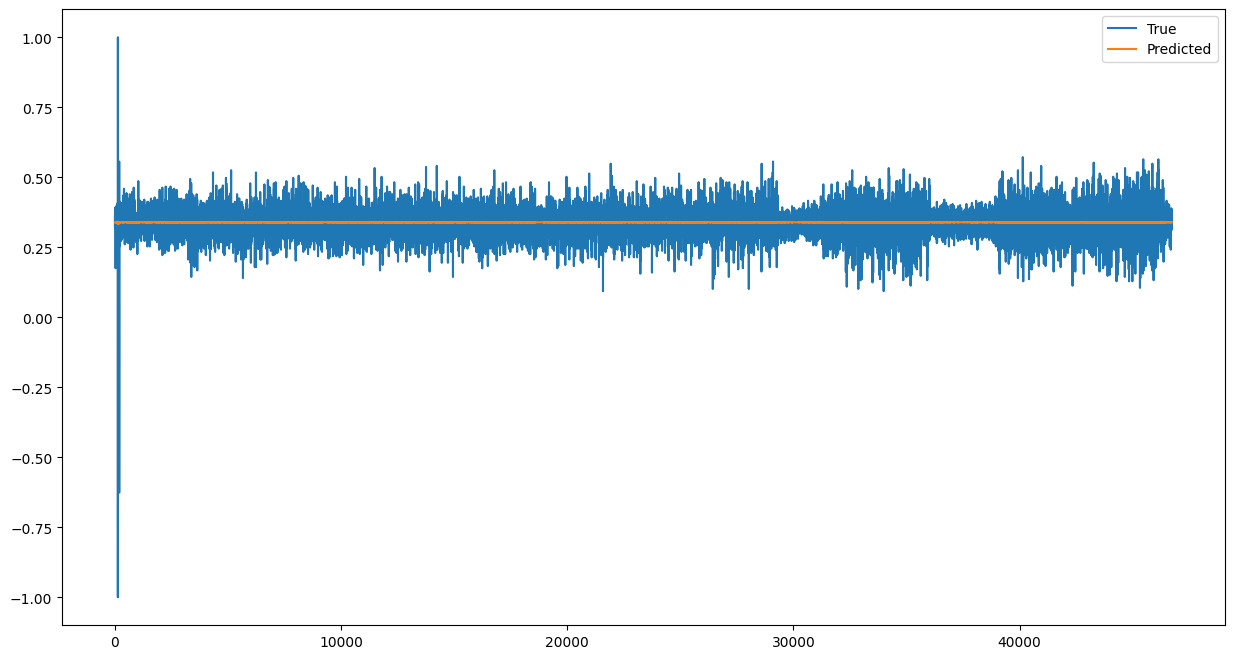

In [46]:
# Make predictions

with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.figure(figsize=(15, 8))
plt.plot(y_train.cpu().numpy(), label='True')
plt.plot(predicted, label='Predicted')
plt.legend()

In [47]:
# Inverse transform the df

train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:,0]= train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = copy(dummies[:,0])
train_predictions

array([-0.0082872 , -0.00784496, -0.00797287, ..., -0.00788655,
       -0.00779502, -0.0083186 ])

In [48]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:,0]= y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = copy(dummies[:,0])
new_y_train

array([ 0.04999998,  0.01999998, -0.06000003, ...,  0.04999998,
       -0.06000003,  0.05999998])

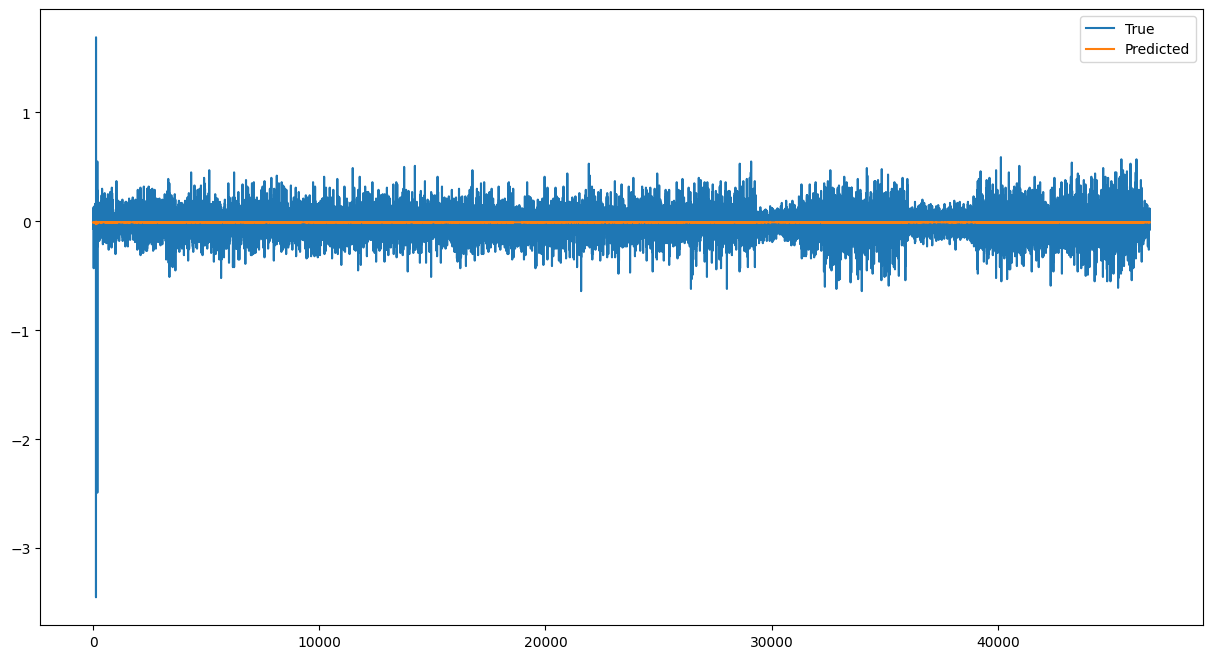

In [49]:
# Plot the predictions

plt.figure(figsize=(15, 8))
plt.plot(new_y_train, label='True')
plt.plot(train_predictions, label='Predicted')
plt.legend()


In [50]:
# Make predictions on the test set

test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:,0]= test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = copy(dummies[:,0])
test_predictions

array([-0.00778629, -0.00810889, -0.00773229, ..., -0.00817989,
       -0.00824224, -0.00833009])

In [51]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:,0]= y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = copy(dummies[:,0])
new_y_test

array([-0.01000002,  0.06999998,  0.08999998, ..., -0.03000003,
       -0.05000003, -0.12000003])

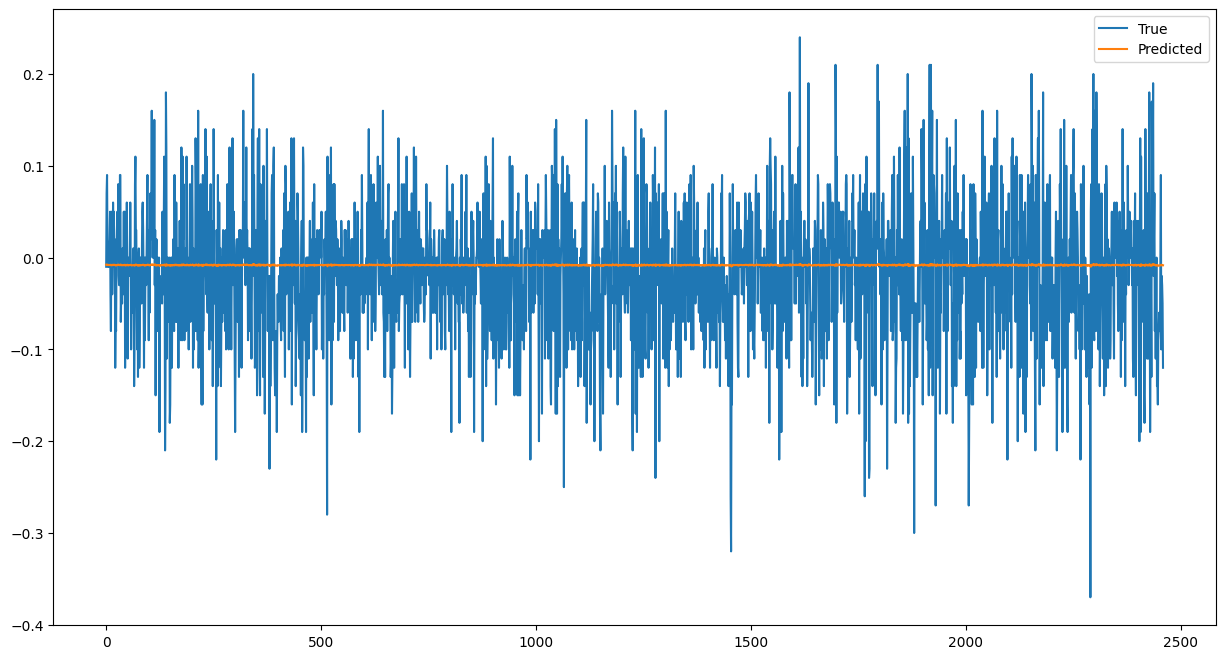

In [52]:
plt.figure(figsize=(15, 8))
plt.plot(new_y_test, label='True')
plt.plot(test_predictions, label='Predicted')
plt.legend()
